# **Haar Cascade with Image Augmentation**

In [1]:
# 2021 (c) Micha Johannes Birklbauer
#
# https://github.com/t0xic-m/
# micha.birklbauer@gmail.com

In [29]:
## useful: https://docs.opencv.org/3.4/dc/d88/tutorial_traincascade.html

In [1]:
import numpy as np
import cv2 
import os
import subprocess
import fileinput
import time


# path definitions
pp = "D:\\Users\\Micha\\Documents\\GitHub\\object_localisation\\notebooks\\" # project_path
trainImgPathPos = pp + "haar_cascade_aug\\refImages_raw"
# false images taken from:
# https://ai.vub.ac.be/
# http://arti.vub.ac.be/research/colour/data/imagesets.zip
trainImgPathNeg = pp + "haar_cascade_aug\\false_images"

openCVbinPath = pp + "haar_cascade\\opencv\\build\\x64\\vc15\\bin"
openCVAnnotationToolExe = "opencv_annotation.exe"
openCVSamplesToolExe = "opencv_createsamples.exe"
openCVTrainCascadeToolExe = "opencv_traincascade.exe"
cascadeResultPath = pp + "haar_cascade_aug\\trained_cascade"

tgtFileExtensionTuple = ext = [".JPEG", ".jpg", ".png"]
fileDictName = "out.txt"
annotationFileName = "annotation.txt"
vectorFileName = "samples.vect"

In [2]:
def prepareSamplesAsVectFile(annotationFilePath, bgImages, vectorFileName, doShow = False) :
    prepareSamplesCommand = os.path.join(openCVbinPath, openCVSamplesToolExe)
    vectorFile = os.path.join(annotationFilePath, vectorFileName)
    annotationFile = os.path.join(annotationFilePath, annotationFileName)
    numVal = 500
    widthVal = 32
    heightVal = 64
    bgThreshVal = 0
    maxAngleVal = 0
    prepareSamplesCommand = prepareSamplesCommand + " -vec " + str(vectorFile) + " -info " + \
    str(annotationFile) + " -bg " + str(bgImages) + " -num " + str(numVal) + " -w " + str(widthVal) + " -h " + str(heightVal)
    if doShow:
        prepareSamplesCommand = prepareSamplesCommand + " -show"
    print("trying to call command: " + prepareSamplesCommand)
    os.system(prepareSamplesCommand)

def trainHaarCascade(cascadeResultPath, annotationFilePath, vectorFileName, bgImages) :
    vectorFile = os.path.join(annotationFilePath, vectorFileName)
    prepareSamplesCommand = os.path.join(openCVbinPath, openCVTrainCascadeToolExe)
    widthVal = 32
    heightVal = 64
    numStages = 20
    numPositives = 100
    numNegatives = 200
    maxFalseAlarmRate = 0.6

    prepareSamplesCommand = prepareSamplesCommand + " -data " + str(cascadeResultPath) + " -vec " + str(vectorFile) + " -bg " + \
    str(bgImages) + " -w " + str(widthVal) + " -h " + str(heightVal) + " -numStages " + str(numStages) + " -numPos " + \
    str(numPositives) + " -numNeg " + str(numNegatives) + " -maxFalseAlarmRate " + str(maxFalseAlarmRate)
    print("trying to call command: " + prepareSamplesCommand)
    os.system(str(prepareSamplesCommand))
    input("Press Enter to continue...")

In [3]:
import pandas as pd

df = pd.read_csv("samples_aug.csv")
df.head()

,NAME,ymin,ymax,xmin,xmax
0,000015774.jpg,208.0,572.0,428.0,877.0
1,000980053.jpg,170.0,483.0,388.0,780.0
2,001693075.jpg,149.0,527.0,581.0,721.0
3,001756546.jpg,81.0,313.0,498.0,593.0
4,002230170.jpg,89.0,421.0,145.0,453.0


## **Prepare out.txt files**

In [4]:
lines = ""
for index, row in df.iterrows():
    lines = lines + str(row["NAME"]) + "\n"
    
with open("haar_cascade_aug/refImages_raw/out.txt", "w") as f:
    f.write(lines)
    f.close()

In [5]:
neg_filelist = os.listdir("haar_cascade_aug/false_images")
lines = ""
for item in neg_filelist:
    lines = lines + pp + "haar_cascade_aug\\false_images\\" + str(item) + "\n"

with open("haar_cascade_aug/false_images/out.txt", "w") as f:
    f.write(lines)
    f.close()

## **Prepare annotation file**

In [6]:
lines = ""
for index, row in df.iterrows():
    lines = lines + str(row["NAME"]) + " 1 " + str(int(row["xmin"])) + " " + str(int(row["ymin"])) + " " + \
    str(int(row["xmax"]) - int(row["xmin"])) + " " + str(int(row["ymax"]) - int(row["ymin"])) + "\n"
    
with open("haar_cascade_aug/refImages_raw/annotation.txt", "w") as f:
    f.write(lines)
    f.close()

## **Prepare samples**

In [7]:
## do this manually via terminal
## e.g. python haar_cascade_aug_1.py
# prepareSamplesAsVectFile(trainImgPathPos, os.path.join(trainImgPathNeg, fileDictName), vectorFileName)

## **Train Haar Cascade**

In [8]:
## do this manually via terminal
## e.g. python haar_cascade_aug_2.py
# trainHaarCascade(cascadeResultPath, trainImgPathPos, vectorFileName, os.path.join(trainImgPathNeg, fileDictName))

## **Haar Cascade Results**

In [27]:
from matplotlib import pyplot as plt
import imageio

cascade = cv2.CascadeClassifier("haar_cascade_aug/trained_cascade/cascade.xml")

# return [xmin, ymin, xmax, ymax]
def get_box(filename, strat = 1, i = 0):
    def get_box_alt(filename, i = i):
        img = cv2.imread(filename)
        result = cascade.detectMultiScale(img)
        if len(result) > i:
            return [result[i][0], result[i][1], result[i][0] + result[i][2], result[i][1] + result[i][3]]
        else:
            return [0, 0, 0, 0]

    def get_box_minmax(filename):
        img = cv2.imread(filename)
        result = cascade.detectMultiScale(img)
        xmin = []
        xmax = []
        ymin = []
        ymax = []
        if len(result) > 0:
            for res in result:
                xmin.append(res[0])
                ymin.append(res[1])
                xmax.append(res[0] + res[2])
                ymax.append(res[1] + res[3])
            return [min(xmin), min(ymin), max(xmax), max(ymax)]
        else:
            return [0, 0, 0, 0]
        
    def get_box_mean(filename):
        img = cv2.imread(filename)
        result = cascade.detectMultiScale(img)
        xmin = []
        xmax = []
        ymin = []
        ymax = []
        if len(result) > 0:
            for res in result:
                xmin.append(res[0])
                ymin.append(res[1])
                xmax.append(res[0] + res[2])
                ymax.append(res[1] + res[3])
            return [np.mean(xmin), np.mean(ymin), np.mean(xmax), np.mean(ymax)]
        else:
            return [0, 0, 0, 0]
        
    if strat == 1:
        return get_box_minmax(filename)
    elif strat == 2:
        return get_box_mean(filename)
    else:
        return get_box_alt(filename, i)

# return image with bounding box + save to current directory
def visualize_bbox(filename, bbox = None, show = False, save = True):
    img = imageio.imread(filename, as_gray = False)
    if bbox is not None:
        start_x = round(bbox[0])
        start_y = round(bbox[1])
        end_x = round(bbox[2])
        end_y = round(bbox[3])
        new_img = img.copy()
        new_img = cv2.rectangle(new_img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
        if show:
            plt.figure()
            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(img)
            axarr[1].imshow(new_img)
            plt.show()   
        if save:
            imageio.imwrite(filename.split(".")[0] + "_bb.jpg", new_img)
        return new_img
    else:
        print("WARNING: No bounding box provided!")
        if save:
            imageio.imwrite(filename.split(".")[0] + "_bb.jpg", img)
        return img

## **Test on a sample image**

<Figure size 432x288 with 0 Axes>

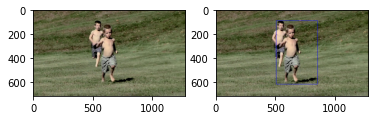

In [28]:
test = {"filename": "../data/test_images/000001163.jpg"}
test["bbox"] = get_box(test["filename"])
visualize_bbox(test["filename"], test["bbox"], show = True, save = False);

## **Testing on our test sample**

In [29]:
test_df = pd.read_csv("../data/samples_test.csv")
test_df.head()

,NAME,ymin,ymax,xmin,xmax
0,002094496.jpg,266.0,1080.0,887.0,1686.0
1,007055006.jpg,100.0,274.0,282.0,429.0
2,007349675.jpg,226.0,437.0,87.0,361.0
3,011151221.jpg,82.0,349.0,239.0,429.0
4,018050712.jpg,147.0,984.0,573.0,1919.0


In [30]:
def pred_boxes(df):
    filepath = "../data/samples_test/" + str(df["NAME"])
    # returns [xmin, ymin, xmax, ymax]
    bbox = get_box(filepath)
    if bbox is not None:
        df["ymin_pred"] = float(round(bbox[1]))
        df["ymax_pred"] = float(round(bbox[3]))
        df["xmin_pred"] = float(round(bbox[0]))
        df["xmax_pred"] = float(round(bbox[2]))
    return df
    
test_df = test_df.apply(pred_boxes, axis = 1)

test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred
0,002094496.jpg,266.0,1080.0,887.0,1686.0,2.0,1075.0,36.0,1917.0
1,007055006.jpg,100.0,274.0,282.0,429.0,110.0,476.0,87.0,638.0
2,007349675.jpg,226.0,437.0,87.0,361.0,98.0,476.0,189.0,570.0
3,011151221.jpg,82.0,349.0,239.0,429.0,28.0,446.0,56.0,453.0
4,018050712.jpg,147.0,984.0,573.0,1919.0,9.0,1072.0,45.0,1914.0


In [31]:
test_df.to_csv("haar_cascade_aug_results/samples_test_pred.csv", index = False)

## **Calculating mAP**

In [32]:
# implementation according to: https://datanics.blogspot.com/2020/11/understanding-mean-average-precision.html

# jaccard index
def IoU(df):
    # determining the minimum and maximum -coordinates of the intersection rectangle
    xmin_inter = max(df["xmin"], df["xmin_pred"])
    ymin_inter = max(df["ymin"], df["ymin_pred"])
    xmax_inter = min(df["xmax"], df["xmax_pred"])
    ymax_inter = min(df["ymax"], df["ymax_pred"])
 
    # calculate area of intersection rectangle
    inter_area = max(0, xmax_inter - xmin_inter + 1) * max(0, ymax_inter - ymin_inter + 1)
 
    # calculate area of actual and predicted boxes
    actual_area = (df["xmax"] - df["xmin"] + 1) * (df["ymax"] - df["ymin"] + 1)
    pred_area = (df["xmax_pred"] - df["xmin_pred"] + 1) * (df["ymax_pred"] - df["ymin_pred"] + 1)
 
    # computing intersection over union
    iou = inter_area / float(actual_area + pred_area - inter_area)
 
    # return the intersection over union value
    return iou

test_df["IoU"] = test_df.apply(IoU, axis = 1)
test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU
0,002094496.jpg,266.0,1080.0,887.0,1686.0,2.0,1075.0,36.0,1917.0,0.319958
1,007055006.jpg,100.0,274.0,282.0,429.0,110.0,476.0,87.0,638.0,0.119668
2,007349675.jpg,226.0,437.0,87.0,361.0,98.0,476.0,189.0,570.0,0.220406
3,011151221.jpg,82.0,349.0,239.0,429.0,28.0,446.0,56.0,453.0,0.306952
4,018050712.jpg,147.0,984.0,573.0,1919.0,9.0,1072.0,45.0,1914.0,0.564027


In [33]:
# creating column 'TP/FP' which will store TP for True positive and FP for False positive
# if IOU is greater than 0.5 then TP else FP
test_df["TP/FP"] = test_df["IoU"].apply(lambda x: "TP" if x >= 0.5 else "FP")
test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU,TP/FP
0,002094496.jpg,266.0,1080.0,887.0,1686.0,2.0,1075.0,36.0,1917.0,0.319958,FP
1,007055006.jpg,100.0,274.0,282.0,429.0,110.0,476.0,87.0,638.0,0.119668,FP
2,007349675.jpg,226.0,437.0,87.0,361.0,98.0,476.0,189.0,570.0,0.220406,FP
3,011151221.jpg,82.0,349.0,239.0,429.0,28.0,446.0,56.0,453.0,0.306952,FP
4,018050712.jpg,147.0,984.0,573.0,1919.0,9.0,1072.0,45.0,1914.0,0.564027,TP


In [34]:
# calculating Precision and recall
Precision = []
Recall = []

TP = FP = 0
FN = len(test_df["TP/FP"] == "TP")
for index , row in test_df.iterrows():     
    if row["IoU"] > 0.5:
        TP = TP + 1
    else:
        FP = FP + 1    

    try:
        AP = TP / (TP + FP)
        Rec = TP / (TP + FN)
    except ZeroDivisionError:
        AP = Recall = 0.0
    
    Precision.append(AP)
    Recall.append(Rec)


test_df["Precision"] = Precision
test_df["Recall"] = Recall

test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU,TP/FP,Precision,Recall
0,002094496.jpg,266.0,1080.0,887.0,1686.0,2.0,1075.0,36.0,1917.0,0.319958,FP,0.0,0.000000
1,007055006.jpg,100.0,274.0,282.0,429.0,110.0,476.0,87.0,638.0,0.119668,FP,0.0,0.000000
2,007349675.jpg,226.0,437.0,87.0,361.0,98.0,476.0,189.0,570.0,0.220406,FP,0.0,0.000000
3,011151221.jpg,82.0,349.0,239.0,429.0,28.0,446.0,56.0,453.0,0.306952,FP,0.0,0.000000
4,018050712.jpg,147.0,984.0,573.0,1919.0,9.0,1072.0,45.0,1914.0,0.564027,TP,0.2,0.019608


In [35]:
#calculating Interpolated Precision
test_df["Precision_interpol"] = test_df.groupby("Recall")["Precision"].transform("max")
test_df.head()

,NAME,ymin,ymax,xmin,xmax,ymin_pred,ymax_pred,xmin_pred,xmax_pred,IoU,TP/FP,Precision,Recall,Precision_interpol
0,002094496.jpg,266.0,1080.0,887.0,1686.0,2.0,1075.0,36.0,1917.0,0.319958,FP,0.0,0.000000,0.0
1,007055006.jpg,100.0,274.0,282.0,429.0,110.0,476.0,87.0,638.0,0.119668,FP,0.0,0.000000,0.0
2,007349675.jpg,226.0,437.0,87.0,361.0,98.0,476.0,189.0,570.0,0.220406,FP,0.0,0.000000,0.0
3,011151221.jpg,82.0,349.0,239.0,429.0,28.0,446.0,56.0,453.0,0.306952,FP,0.0,0.000000,0.0
4,018050712.jpg,147.0,984.0,573.0,1919.0,9.0,1072.0,45.0,1914.0,0.564027,TP,0.2,0.019608,0.2


In [36]:
prec_at_rec = []

for recall_level in np.linspace(0.0, 1.0, 11):
    try:
        x = test_df[test_df["Recall"] >= recall_level]["Precision"]
        prec = max(x)
    except:
        prec = 0.0
    prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec)
print("11 point precision is ", prec_at_rec)
print("mAP is ", avg_prec)

11 point precision is  [0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mAP is  0.018181818181818184


In [37]:
# strat 0: mAP = 0
# strat 1: mAP = 0.018181818181818184
# strat 2: mAP = 0

In [38]:
test_df.to_csv("haar_cascade_aug_results/samples_test_pred2.csv", index = False)